In [1]:
from pathlib import Path
import os
import pandas as pd
import json
import re
import pymupdf

from bisect import bisect_left
from rapidfuzz import fuzz, process
import diff_match_patch as dmp_module

import nltk
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

from pagewise_utils import assemble_pagewise_raw_parser_output, get_list_of_pdf_page_lists, read_out_parser_output, get_unique_pdf_paths_from_data_list_dict
from pagewise_utils import get_text_by_path, partition_fulltext_by_pagelist, end_of_path

from benchmark_for_split_performance import s1, s2, s3, s4

In [2]:
def calculate_bleu(reference: str, hypothesis: str) -> float:
    """
    Compute BLEU score
    """
    reference_tokens = nltk.word_tokenize(reference)
    hypothesis_tokens = nltk.word_tokenize(hypothesis)
    
    # Use SmoothingFunction to handle cases with zero counts in higher-order n-grams
    smoothing_function = SmoothingFunction().method1
    
    return sentence_bleu([reference_tokens], hypothesis_tokens, smoothing_function=smoothing_function)


# Need to improve `partition_fulltext_by_pagelist()`
- split per page is fairly coarse (easily off by 1/2 page) --> significant problem

Improve `assemble_pagewise_raw_parser_output` (called in `main` of `create_page_wise_output_tables_raw.py` $\Rightarrow$ `_raw.csv`)

Method `partition_fulltext_by_pagelist()` is key to splitting up text - it does NOT call further methods.
.

#### 1. Small dataset to test split ability
Two (short) papers per domain.

#### 2. REFERENCES

Correlations of BLEU scores as computed against approximate (`html`) and groundtruth (`actual`) reference). Moreover, two BLEU scores provided to see how good `PyMuPDF` text (per page) is as compared to `actual` groundtruht.
```
df['bleu_actual'] = df.apply(lambda row: calculate_bleu(row['html'], row['actual']), axis=1)
df['bleu_corr_act'] = df.apply(lambda row: calculate_bleu(row['pymupdf'], row['actual']), axis=1)
```

#### All `pages` ($n=58$)
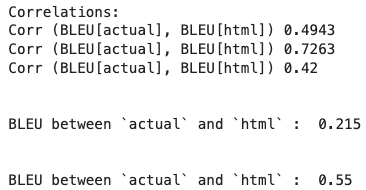

#### `page<5` only ($n=20$)
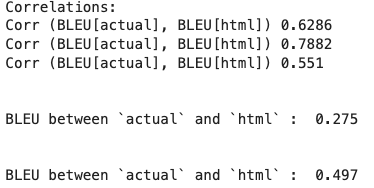

#### `page=0` only ($n=4$
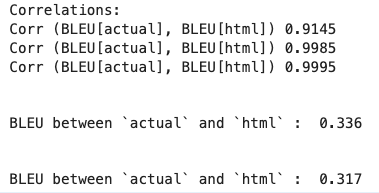

In [3]:
# The reference table for computation (DEFAULT: ...database/parser_output_raw.csv)
p = Path('/eagle/projects/argonne_tpc/siebenschuh/aurora_gpt/database/parser_output_raw.csv')
p_root = Path('/eagle/projects/argonne_tpc/siebenschuh/aurora_gpt/joint')

# load
df_fulltext = pd.read_csv(p, sep='|')

#### 2. New `partition_fulltext_by_pagelist()`

In [4]:
get_list_of_pdf_page_lists(i=0, 
                           p_pdf_root=Path('/home/siebenschuh/Projects/dataprep/code/statistical_tasks/split_test'),
                           n_max_core=1).keys()


dict_keys(['/home/siebenschuh/Projects/dataprep/code/statistical_tasks/split_test/bmc/pdf/10.1186_s12938-022-00977-w.pdf', '/home/siebenschuh/Projects/dataprep/code/statistical_tasks/split_test/mdpi/pdf/2227-9717.9.8.1441.pdf', '/home/siebenschuh/Projects/dataprep/code/statistical_tasks/split_test/arxiv/pdf/2207.11282v4.pdf', '/home/siebenschuh/Projects/dataprep/code/statistical_tasks/split_test/biorxiv/pdf/10.1101_2019.12.12.871947.pdf'])

In [5]:
def copy_jsonls_over(parser:str='html',
                     output_dir:str=Path('/home/siebenschuh/Projects/dataprep/code/statistical_tasks/split_test')):
    
    """Copies JSONls over from `joint_to_{parsername}` to local dir `./statistical_task/split_test`
    """
    # store dir
    store_dir = Path(output_dir) / f"joint_to_{parser}/parsed_pdfs"
    
    # - create
    os.makedirs(output_dir, exist_ok=True)
    
    # load PDF pagelist chunk (PyMuPDF)
    dict_of_page_lists = get_list_of_pdf_page_lists(i=0, 
                                                    p_pdf_root=output_dir,
                                                    n_max_core=1)
        
    # target PDFs
    benchmark_split_pdf_names = [Path(f).name for f in dict_of_page_lists.keys()]
    jsonl_list = []
    
    # original parser output `aurora_gpt/joint`
    p_parser_output = Path(f'/eagle/projects/argonne_tpc/siebenschuh/aurora_gpt/joint_to_{parser}/parsed_pdfs')
    jsonl_files = [p_parser_output / p for p in os.listdir(p_parser_output) if (p_parser_output / p).is_file()]
    
    for json_f in jsonl_files:
        with open(json_f, 'r') as f:
            for line in f:
                data = json.loads(line)  # corrected to json.loads
                # add
                if Path(data['path']).name in benchmark_split_pdf_names:
                    # replace path
                    data['path'] = str(output_dir / end_of_path(data['path']))
                    print(data['path'])
                    # store
                    jsonl_list.append(data)

    # store
    with open(store_dir / 'out.jsonl', 'w') as f:
        for entry in jsonl_list:
            f.write(json.dumps(entry) + '\n')

    pass


def NEW_partition_fulltext_by_pagelist(fulltext:str, 
                                   page_list:list[str]):
    """
    Splits singular fulltext string (from one parser) by page strings (from other parser).
    
    Combines fuzzy matching and speculative split (from text lengths)
    
    - fulltext[str]        : Parsed full text from one parser  
    - page_list[list[str]] : Parsed text pages from another parser
    """

    # rename
    S = fulltext
    s_list = page_list
    # Dictionary to store the result with page index as key and extracted text as value
    page_splits = {}
    current_position = 0

    # infer approximate lengths for each page based on the length of s_list items
    approx_len_list = [len(s) for s in s_list]

    # loop pages
    for i, s in enumerate(s_list):
        # get the initial guess for the page length
        approx_len = approx_len_list[i]
        guess_position = current_position + approx_len
        
        # find the actual split point by adjusting around the guess
        best_split = S[current_position:guess_position]
        
        # adjust the split point dynamically based on matching the beginning of the page
        match_start = best_split.find(s[:min(100, len(s))])  # first 100 chars for quick fuzzy match
        
        if match_start != -1:
            # Adjust current position based on the best match
            best_split = S[current_position + match_start: current_position + match_start + len(s)]
        
        # store the matched chunk in the dictionary with index i as the key
        page_splits[i] = best_split
        
        # dynamically adjust the current position and the next approximate length
        current_position += len(best_split)
        if i + 1 < len(approx_len_list):
            # Adjust the next approximate length based on how well the match performed
            next_len_diff = len(best_split) - approx_len_list[i]
            approx_len_list[i + 1] += next_len_diff
    
    return page_splits

In [6]:
# copy files: copy original JSONLs over for the 4 benchmark PDFs [ONLY once: check ./split_test/split.../out.jsonl]
if False:
    copy_jsonls_over(parser='html')
    copy_jsonls_over(parser='marker')
    copy_jsonls_over(parser='nougat')
    copy_jsonls_over(parser='pymupdf')

In [7]:
%%time

# compute page-by-page 
df = assemble_pagewise_raw_parser_output(i=-1,
                                         parsers=['html','nougat', 'pymupdf', 'marker'], 
                                         p_pdf_root=Path('/home/siebenschuh/Projects/dataprep/code/statistical_tasks/split_test'),
                                         save_flag=False)

# add filename
df['filename'] = df['path'].astype(str).str.split('/').str[-1]

# append actual (from s1,s2,s3,s4 that are imported - hand-curated)
df_list = []
for s in [s1,s2,s3,s4]:
    df_list.append(pd.DataFrame({'filename' : s['path'].split('/')[-1], 
                                 'actual' : s['pages'],
                                 'page' : range(len(s['pages']))
                                }))
# one frame of `actual` for all files
df_actual = pd.concat(df_list, axis=0, ignore_index=True)

# merged
df_merged = pd.merge(left=df, right=df_actual, on=['filename', 'page'], how='left')
df_merged = df_merged[~df_merged['actual'].isna()]

# rename merged frame
df = df_merged

# restrict pages
#df = df[df['page'] <= 0]

CPU times: user 24.7 ms, sys: 1.48 s, total: 1.51 s
Wall time: 2.32 s


In [8]:
# compute
df['bleu_actual'] = df.apply(lambda row: calculate_bleu(row['html'], row['actual']), axis=1)
df['bleu_corr_act'] = df.apply(lambda row: calculate_bleu(row['pymupdf'], row['actual']), axis=1)

# compute
df['bleu_nougat'] = df.apply(lambda row: calculate_bleu(row['html'], row['nougat']), axis=1)
df['bleu_pymupdf'] = df.apply(lambda row: calculate_bleu(row['html'], row['pymupdf']), axis=1)
df['bleu_marker'] = df.apply(lambda row: calculate_bleu(row['html'], row['marker']), axis=1)

# compute
df['bleu_actual_nougat'] = df.apply(lambda row: calculate_bleu(row['actual'], row['nougat']), axis=1)
df['bleu_actual_pymupdf'] = df.apply(lambda row: calculate_bleu(row['actual'], row['pymupdf']), axis=1)
df['bleu_actual_marker'] = df.apply(lambda row: calculate_bleu(row['actual'], row['marker']), axis=1)



In [9]:
print('Correlations:')
for parser in ['nougat', 'marker', 'pymupdf']:
    print('Corr (BLEU[actual], BLEU[html])', df[[f'bleu_actual_{parser}', f'bleu_{parser}']].corr().iloc[0, 1].round(4))

print("\n\nBLEU between `actual` and `html` : ", df['bleu_actual'].mean().round(3))
print("\n\nBLEU between `actual` and `html` : ", df['bleu_corr_act'].mean().round(3))

Correlations:
Corr (BLEU[actual], BLEU[html]) 0.5022
Corr (BLEU[actual], BLEU[html]) 0.7049
Corr (BLEU[actual], BLEU[html]) 0.4352


BLEU between `actual` and `html` :  0.208


BLEU between `actual` and `html` :  0.549
